In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reset -sf

In [2]:
import importlib
import Deproject_v1_0 
from Deproject_test import *
from Deproject_plots import DM_plt_prefs
DM_plt_prefs()
import matplotlib.pyplot as plt
from scipy import sparse as scisp
from scipy.optimize import approx_fprime
import os
import cProfile
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from timeit import default_timer as timer

from astropy.io.ascii import read as tableread
import astropy.units as u
import astropy.coordinates as coord

coord.Galactic()
%cd ~/DeprojectionProject/

/Users/danielmikkola/DeprojectionProject


In [4]:
%cd ~/Documents/faststats/faststats/
from fkde import *
def kdeplot(x,y,grid,no_c,bw_a):
    Z,ax = fastkde(x,y,gridsize=grid,nocorrelation=no_c,adjust=bw_a)#,weights,adjust)
    xlen,ylen = np.shape(Z)
    X,Y = np.meshgrid(np.linspace(ax[0],ax[1],xlen),np.linspace(ax[0],ax[1],ylen))
    return X,Y,Z
%cd ~/DeprojectionProject/

/Users/danielmikkola/Documents/faststats/faststats
/Users/danielmikkola/DeprojectionProject


In [5]:
def rot(x,y,deg):
    xf = x.flatten(); xf = xf.reshape(len(xf),1)
    yf = y.flatten(); yf = yf.reshape(len(yf),1)
    pos = np.hstack((xf,yf))
    
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    pos = np.dot(pos, R.T)
    
    x = pos[:,0].reshape(x.shape)
    y = pos[:,1].reshape(y.shape)
    return x,y

def f(x,y,z,lim):
    x,y = rot(x,y,45)
    val = (lim-np.abs(x))**4 + (lim-np.abs(y))**4 + (lim-np.abs(z))**4
    return val/np.sum(val)


def pyramid_sample(N_sample,r,c):
    # Velocities
    xc,yc,zc = c
    N = 100
    X = np.linspace(-r,r,N)
    Y = np.linspace(-r,r,N)
    Z = np.linspace(-r,r,N)
    
    XX = X.reshape(1,N,1)*np.ones((N,1,N))
    YY = Y.reshape(N,1,1)*np.ones((1,N,N))
    ZZ = Z.reshape(1,1,N)*np.ones((N,N,1))
    
    P = f(XX,YY,ZZ,r+np.max(c))
    
    rrind = np.ravel_multi_index(np.indices(XX.shape), XX.shape).ravel()
    prob = np.ravel(P)
    smp = np.random.choice(rrind, size=N_sample, p=prob)
    smpx, smpy, smpz = np.asarray(np.unravel_index(smp, XX.shape))
    
    XX = XX + xc
    ZZ = YY + yc
    YY = ZZ + zc
    
    vxvals = XX[smpx, smpy, smpz]
    vyvals = YY[smpx, smpy, smpz]
    vzvals = ZZ[smpx, smpy, smpz]
    
    # Positions
    xmax, ymax, zmax = np.array([100,100,100])/np.sqrt(3)    
    xmin, ymin, zmin = -xmax,-ymax,-zmax
    
    xvals = (np.random.rand(N_sample) * (xmax - xmin) + xmin)
    yvals = (np.random.rand(N_sample) * (ymax - ymin) + ymin)
    zvals = (np.random.rand(N_sample) * (zmax - zmin) + zmin)
    return xvals, yvals, zvals, vxvals, vyvals, vzvals

## Generate gaussian sample

In [6]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)

In [7]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate pyramid-like sample from distribution

In [ ]:
np.random.seed(0)
x, y, z, vx, vy, vz = pyramid_sample(int(1e4),100, c=(0,0,0))

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)



In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate  fake Galactic samples

From simulated galaxy:

Loading data

In [ ]:
N = 5000 #Number of stars we want to use in our sample
dat = np.load('DATA/simgal.npy')

Select a sample around with radius 2 kpc around 8 kpc

In [ ]:
x,y,z,vx,vy,vz = dat
R = np.sqrt((x-8)**2 + y**2)
snbh = R < 2
dat = dat[:,snbh]
I = np.random.randint(low=0,high=np.sum(snbh),size=N)

x,y,z,vx,vy,vz = dat[:,I]

# Center x, y and vy, so they look like they're relative to the LSR
x = x - np.median(x)
y = y - np.median(y)
vy = vy - np.median(vy)

Prepare for astropy

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)


In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Inspect sample

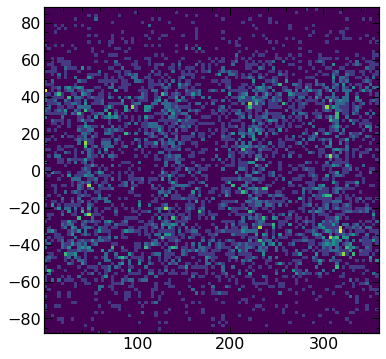

In [8]:
plt.hist2d(np.array(sample.l),np.array(sample.b),100)
plt.show()

In [10]:
n = np.array([20,20,20])
dv = np.array([10,10,10])
vmin = np.array([-100,-100,-100])

In [11]:
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

sanity_check(pvals,rhatvals,phi0,vmin,dv,n)


DB98 mean                  : ===> [ 9.003072 -1.16898   8.411974]
computed f(v) mean         : ===> [-0.552587  4.633061  4.198976]
DB98 dispersions           : ===> [27.151004 29.426995 27.947672]
Computed f(v) dispersions  : ===> [49.869129 48.864518 49.234466]




In [12]:
alpha_guess = 1e-8

v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

t0 = timer()
mxl, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess)
time = str((timer() - t0)/60)
print(time + ' mins')

sanity_check(pvals,rhatvals,mxl,vmin,dv,n)

Allocated RAM: 5.97 GB  
Required RAM : 0.32 GB | Block size = 93348
Fast Numpy Kvals run possible, running...

Finished kvals.

Started fmin_cg...
Optimization terminated successfully.
         Current function value: 10.322392
         Iterations: 177
         Function evaluations: 705
         Gradient evaluations: 705
0.16042869365000006 mins

DB98 mean                  : ===> [ 9.003072 -1.16898   8.411974]
computed f(v) mean         : ===> [ 8.820774 -1.410889  8.576028]
DB98 dispersions           : ===> [27.151004 29.426995 27.947672]
Computed f(v) dispersions  : ===> [29.236862 31.673457 30.468048]




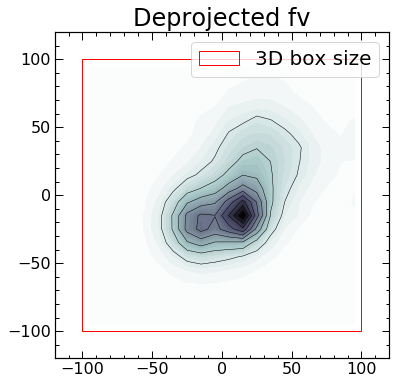

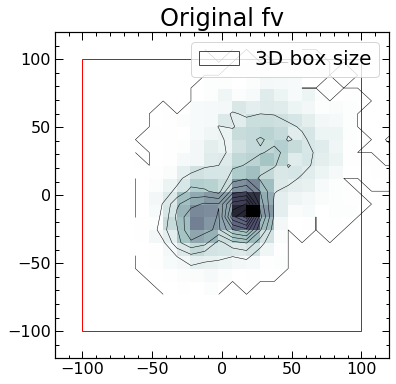

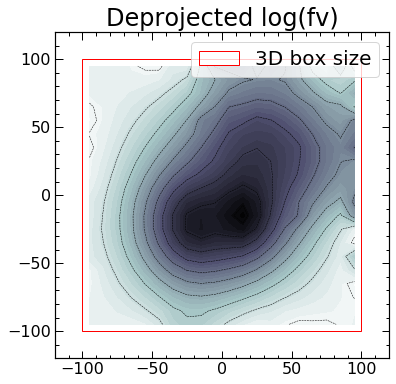

In [13]:
dx, dy = dv[0], dv[1]
vxmin, vymin = vmin[0], vmin[1]
nx, ny = n[0], n[1]
vxmax, vymax = vxmin+nx*dx,vymin+ny*dy

x0, y0 = vxmin, vymin
x1, y1 = vxmax, vymax

xbins = np.arange(x0,x1+dx,dx)
ybins = np.arange(y0,y1+dy,dy)

xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X,Y] = np.meshgrid(xc,yc);

fv = np.exp(mxl)

fvlog = np.log10(fv+1)
xl = 120
yl = 120
twodfv = np.sum(fv,axis=2)
plt.figure()
plt.contourf(X,Y,twodfv.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.contour(X,Y,twodfv.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Deprojected fv')

X2,Y2,Z = kdeplot(np.array(vx),np.array(vy),(50,50),False,2)
Z,xbins,ybins = np.histogram2d(np.array(vx),np.array(vy),20)
xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X2,Y2] = np.meshgrid(xc,yc);

plt.figure()
#plt.contourf(X2,Y2,Z.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.pcolormesh(X2,Y2,Z.T,cmap='bone_r')
plt.contour(X2,Y2,Z.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Original fv')

plt.figure()
plt.contourf(X,Y,np.log10(twodfv.T),40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.contour(X,Y,np.log10(twodfv.T),10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Deprojected log(fv)')
plt.show()

Investigating grad_L

In [ ]:
f,ax = plt.subplots(5,4,sharex=True,sharey=True,figsize=(20,20),frameon=False)

k = 0
for i in range(5):
    for j in range(4):
        ax[i,j].pcolormesh(mxl[:,:,k],cmap = plt.cm.get_cmap('viridis'))
        ax[i,j].set_title('z sheet %s' % k)
        k += 1
plt.show()

## Alternative sec_der

In [ ]:
from scipy.interpolate import interpn

def plotphi(phi):
    plt.figure(figsize=(4,3))
    im = plt.pcolormesh(phi.T,cmap = plt.cm.get_cmap('viridis'))
    plt.colorbar(im)
    plt.show()

def extrapolate_box(box):
    '''This function takes a 3D grid box and replaces the values along the outer edges with extrapolated values
    based on the inner box using scipy.interpolate.interpn'''
    (nx,ny,nz) = box.shape

    points = (np.arange(1,nx-1), 
              np.arange(1,ny-1),
              np.arange(1,nz-1))

    IA = np.indices(box.shape).transpose(3,1,2,0)

    xedges = np.concatenate((IA[:,0,:,:].reshape(nx**2,3), IA[:,-1,:,:].reshape(nx**2,3)), axis=0)
    yedges = np.concatenate((IA[:,:,0,:].reshape(ny**2,3), IA[:,:,-1,:].reshape(ny**2,3)), axis=0)
    zedges = np.concatenate((IA[0,:,:,:].reshape(nz**2,3), IA[-1,:,:,:].reshape(nz**2,3)), axis=0)
    edge_coords = np.concatenate((xedges,yedges,zedges),axis=0)
    edge_coords = np.unique(edge_coords,axis=0) # remove duplicate entries

    I_edges = np.ones((nx,ny,nz),dtype=bool)
    I_edges[1:-1,1:-1,1:-1] = np.zeros((nx-2,ny-2,nz-2),dtype=bool)
    edge_vals = interpn(points, box[1:-1, 1:-1, 1:-1], edge_coords, method='linear', bounds_error=False, fill_value=None)
    box[I_edges] = edge_vals
    return box



def sec_der(phi, sigma2, dv):

    nx, ny, nz = phi.shape
    dvx, dvy, dvz = dv
    dv2 = dv ** 2
    sigma2x, sigma2y, sigma2z = sigma2

    nxx, nyy, nzz = nx + 2, ny + 2, nz + 2

    phip = np.zeros((nxx, nyy, nzz))  # new larger box

    phip[1:-1, 1:-1, 1:-1] = phi  # puts the phi-box in the centre of our larger box
    extrapolate_box(phip)



    phi_fac = np.array([phip[0:nxx - 2, 1:-1, 1:-1] + phip[2:nxx, 1:-1, 1:-1],
                        phip[1:-1, 0:nyy - 2, 1:-1] + phip[1:-1, 2:nyy, 1:-1],
                        phip[1:-1, 1:-1, 0:nzz - 2] + phip[1:-1, 1:-1, 2:nzz]])

    phi_arrx = (sigma2[0] / dv2[0]) * (phi_fac[0] - 2 * phi)
    phi_arry = (sigma2[1] / dv2[1]) * (phi_fac[1] - 2 * phi)
    phi_arrz = (sigma2[2] / dv2[2]) * (phi_fac[2] - 2 * phi)


    phi_arr = phi_arrx + phi_arry + phi_arrz
    extrapolate_box(phi_arr)
    return phi_arr

In [ ]:
%cd DATA/
pvals = np.load('TEST/pvals.npy')
rhatvals = np.load('TEST/rhatvals.npy')
mxl = np.load('TEST/mxl.npy')

In [ ]:
Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)

In [ ]:
args = (Kvals, len(pvals), alpha_guess, dv, n, sigma2)

In [ ]:
get_negL(mxl.ravel(),Kvals, len(pvals), alpha_guess, dv, n, sigma2)

In [ ]:
Kvals, N, alpha, dv, n, sigma2 = args
nx, ny, nz = n
dvx, dvy, dvz = dv
phi = np.ravel(mxl)

In [ ]:
plotphi(phi_arr[1:-1, 1:-1,9])
phi_arr[1:-1, 1:-1, 1:-1] = np.min(phi_arr)
plotphi(phi_arr[1:-1, 1:-1,9])
extrapolate_box(phi_arr)
plotphi(phi_arr[1:-1, 1:-1,9])

In [ ]:
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)
print('phi')
print('phip')
print('phiarrx')
print('phiarrx middle')
print('phiarr')
print('phiarr_extr')
sec_der(phi0,sigma2,dv)

In [ ]:
f,ax = plt.subplots(5,8,sharex=True,sharey=True,figsize=(12,8),frameon=False)

k = 0
for i in range(5):
    k = [z+i for z in range(0,20,5)]
    for j in range(4):
        ax[i,j*2].pcolormesh(phi_arr[:,:,k[j]].T,cmap = plt.cm.get_cmap('viridis'))
        ax[i,j*2].set_title('z sheet %s' % k[j])

        ax[i,j*2+1].pcolormesh(phi0[:,:,k[j]].T,cmap = plt.cm.get_cmap('viridis'))
        ax[i,j*2+1].set_title('z sheet %s' % k[j])
plt.tight_layout()
plt.show()

In [ ]:
def plotphi(phi):
    plt.figure(figsize=(4,3))
    im = plt.pcolormesh(phi.T,cmap='bone_r')
    plt.contour(phi.T,10,origin='lower',colors='k',linewidths=0.5)
    plt.colorbar(im)
    plt.show()
#phip[1:-1, 1:-1] = phi2d 

In [ ]:
X2,Y2,Z = kdeplot(np.array(vx),np.array(vy),(50,50),False,2)
Z,xbins,ybins = np.histogram2d(np.array(vx),np.array(vy),20)
xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X2,Y2] = np.meshgrid(xc,yc);

plt.figure()
plt.pcolormesh(X2,Y2,Z.T,cmap='bone_r')
plt.contour(X2,Y2,Z.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Original fv')

## Check eq 30 on 1d Gaussian

$$ \Xi_{\pmb{n}\pmb{l}} \propto -2\delta_{\pmb{n},\pmb{l}} + \delta_{\pmb{n},\pmb{l} + \pmb{\hat{e}}_i} + \delta_{\pmb{n},\pmb{l} - \pmb{\hat{e}}_i}$$

$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} \rightarrow \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

$$f'(x) =  -\frac{x}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

$$f"(x) =  \frac{x^2 - 1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

In [ ]:
def f_gauss(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def f_gauss_bis(x):
    return (x**2 - 1)*f_gauss(x)



In [ ]:
x = np.linspace(-5,5,15)
vals = f_gauss(x)
sec_der_vals = f_gauss_bis(x)
xi_vals = vals[2:] + vals[:-2] - 2*vals[1:-1]

plt.figure()
plt.plot(x,vals,'b')
plt.plot(x,sec_der_vals,'r')
plt.plot(x[1:-1],xi_vals,'g')

In [ ]:
%matplotlib inline
from ipywidgets import *

def f_gauss(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def f_gauss_bis(x):
    return (x**2 - 1)*f_gauss(x)

def xi_vals(x):
    phi = np.log(f_gauss(x))
    sec_vals = ((vals[2:] + vals[:-2] - 2*vals[1:-1])
    return 

def x_vals(N):
    return np.linspace(-5,5,N)

def plot_func(N):
    x = x_vals(int(N))

    plt.plot(x,f_gauss(x),'b')
    plt.plot(x,f_gauss_bis(x),'r')
    plt.plot(x[1:-1],xi_vals(f_gauss(x)),'g')
    plt.show()

interact(plot_func, N = widgets.FloatSlider(value=10,
                                               min=5,
                                               max=50,
                                               step=5))

In [ ]:
def sec_der(phi, sigma2, dv):

    nx, ny, nz = phi.shape
    dvx, dvy, dvz = dv
    dv2 = dv ** 2
    sigma2x, sigma2y, sigma2z = sigma2

    nxx, nyy, nzz = nx + 2, ny + 2, nz + 2

    phip = np.zeros((nxx, nyy, nzz))  # new larger box
    phip[1:-1, 1:-1, 1:-1] = phi  # puts the phi-box in the centre of our larger box
    extrapolate_box(phip)


    phi_fac = np.array([phip[0:nxx - 2, 1:-1, 1:-1] + phip[2:nxx, 1:-1, 1:-1],
                        phip[1:-1, 0:nyy - 2, 1:-1] + phip[1:-1, 2:nyy, 1:-1],
                        phip[1:-1, 1:-1, 0:nzz - 2] + phip[1:-1, 1:-1, 2:nzz]])

    phi_arrx = (sigma2[0] / dv2[0]) * (phi_fac[0] - 2 * phi)
    phi_arry = (sigma2[1] / dv2[1]) * (phi_fac[1] - 2 * phi)
    phi_arrz = (sigma2[2] / dv2[2]) * (phi_fac[2] - 2 * phi)

    phi_arr = phi_arrx + phi_arry + phi_arrz
    extrapolate_box(phi_arr)
    return phi_arr

In [ ]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

n = np.array([10,10,10])
vmin = np.array([-150,-150,-150])
vmax = -vmin
dv = (vmax - vmin)/n

sigma = np.sqrt(sigma2)
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

In [6]:
np.pad(,1)

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])